**Hands-on 4 – Comparing TensorFlow/Keras and PyTorch**

_This hands-on was created by Thomas Grenier (TensorFlow) and Fabien Millioz (PyTorch), CREATIS, [deepimaging2019](https://deepimaging2019.sciencesconf.org/)_

thomas.grenier@creatis.insa-lyon.fr
fabien.millioz@creatis.insa-lyon.fr


# Introduction

**This file is dedicated to TensorFlow. So be sure to have enabled TensorFlow 1.12 (or higher version).**

Today, we will compare usages of two well-used deep learning frameworks for DNN: [TensorFlow](https://en.wikipedia.org/wiki/TensorFlow) (Google - 2015) and [PyTorch](https://en.wikipedia.org/wiki/PyTorch) (Facebook - 2016). Many others exist as [MXNet](https://en.wikipedia.org/wiki/MXNet), [Caffe](https://en.wikipedia.org/wiki/Caffe_(software)), [Deeplearning4j](https://en.wikipedia.org/wiki/Deeplearning4j), ...

Most of these frameworks have low to high-level APIs, meaning that you can develop the same network with detailed (low-level) functions to coarse (high-level) functions.

Keras is the most used high-level API for TensorFlow. You already enjoyed it during the two previous hands-on sessions. One noticable point for Keras is its ablility to interface TensorFlow, Microsoft Cognitive Toolkit, Theano, or PlaidML frameworks as backend.

From 2017, Keras is supported in TensorFlow's core library. The actual version of TensorFlow is 1.13 but TensorFlow 2.0 will be released soon. 
The main improvements in version 2 are API cleanups, let APIs be more consistent and better integrate TensorFlow with the Python runtime (Eager execution: toward dynamic graphs and easier debugging).


> This practice will detail the usages of Keras and may go deeper in TensorFlow backend.


By the way, two interesting ressources:
 - the google ML courses using TensorFlow: [TensorFlow Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/)
 - The Aurélien Géron's books: [1st Edition](http://shop.oreilly.com/product/0636920052289.do) with TensorFlow 1  and the upcoming [2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) using TensorFlow 2.
 
**About the data and exercices**

This hands-on is computer scientist-oriented more than application-oriented... 

And so, this practice focuses on a meaningless toy example inspired from the MNIST manuscript numbers classification challenge that is considered as the 'hello world' example for neural networks.

Here, we have to recognize wether a brain slice image is axial, sagittal or coronal and comes from MRI T1w, MRI T2w or CT modality. So, there are 9 classes as summarized here:

![Figure 1](./images_TP4/Figure1_SagittalAxialCoronal_small.png)

> Let's go!

# A - Setup

### A1 - First, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to display the figures:

In [1]:
# install some packages (imge reading/processing, graph/image display)
#!pip3 install pillow matplotlib pydot graphviz --user

# Common imports
import numpy as np
from PIL import Image
import os

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
    
def plot_image(image):
    plt.imshow(image, aspect="equal", cmap="gray", interpolation="nearest")
    plt.axis("off")

### A2- And of course we import TensorFlow

In [2]:
import tensorflow as tf
tf.__version__

'1.12.0'

> _**if no error occurs, your working environment is ok and you can go to next part,
> else ... call an assistant for help!**_

## B- How does TensorFlow work?  THIS PART CAN BE SKIPPED 

This section presents TensorFlow and how it works.
This part is for users who would like to understand the low-levels functionnalities in TensorFlow on which neural networks rely.

We start with a simple example where automatic differentiation is used, then we program a step-by-step classical gradient descent.


In [3]:
a_tf = tf.Variable( tf.random_uniform([2, 2], -1.0, 1.0, seed=42), name="a_tf")
print(a_tf)

<tf.Variable 'a_tf:0' shape=(2, 2) dtype=float32_ref>


… it is a tensorflow object which only presents in the current (default) graph without 'value' and must be initialized before being evaluated inside a _Session_.

In [4]:
sess = tf.Session()      # create a session 
sess.run(a_tf.initializer)  # initialize 'a'
print(sess.run(a_tf))       # evaluate and print 'a' 
sess.close()             # close the session

[[0.9045429  0.35481548]
 [0.5906365  0.51156354]]


OK, we can use numpy array to do the same.

In [5]:
import numpy as np
tf.reset_default_graph()

a_np = np.random.rand(2,2)
a    = tf.get_variable( initializer=a_np, name="a")
print(a_np)
print(a_tf)

[[0.34041408 0.52861232]
 [0.0252826  0.29251636]]
<tf.Variable 'a_tf:0' shape=(2, 2) dtype=float32_ref>


We can calculate gradients with automatic differentiation of the function $ c(a) = 3(a+2)^2 $.

In [6]:
print(a)
b = 3*(a+2)**2   
print(b)
c = tf.reduce_mean( b, name="c")
print(c)

init = tf.global_variables_initializer()

sess = tf.InteractiveSession()      # create a session which becomes the current session
init.run()

print()
print( "b = ", b.eval() )
print()
print( "c = ", c.eval() )

tf.InteractiveSession.close(sess)

<tf.Variable 'a:0' shape=(2, 2) dtype=float64_ref>
Tensor("mul:0", shape=(2, 2), dtype=float64)
Tensor("c:0", shape=(), dtype=float64)

b =  [[16.43261416 19.18164084]
 [12.30530884 15.76689377]]

c =  15.921614400605975


Gradient of $c(a)$ is $ \nabla c(a) = \frac{3(a+2)}{2} $.

Here we evaluate it automatically from $c$.

In [7]:
gradients = tf.gradients(c, [a])[0]    # the gradients of function c(a) are calculated 
print(gradients)
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()      # create a session which becomes the current session
init.run()

print(" TF auto gradient \n ", gradients.eval() )

print(" true gradient \n ", 3/2*(a_np+2))  # 
tf.InteractiveSession.close(sess)

Tensor("gradients/add_grad/Reshape:0", shape=(2, 2), dtype=float64)
 TF auto gradient 
  [[3.51062112 3.79291848]
 [3.0379239  3.43877454]]
 true gradient 
  [[3.51062112 3.79291848]
 [3.0379239  3.43877454]]


### An example of gradient descent:

The gradients $\frac{\partial L(y - h(x))}{\partial w}$ and $\frac{\partial L(y - h(x))}{\partial b}$ are computed with:
- $h(x) = \sigma(w.x + b)$
- $\sigma$ is the sigmoid activation function
- $L(y, \hat{y}) = (y - \hat{y})^2$ (quadratic error)
- $y = 0.2$
- $x = 1.5$
- $b = -2$
- $w = 3$

In [8]:
x = tf.constant(1.5)                  #x = torch.tensor([1.5])
y = tf.constant(0.2)                  #y = torch.tensor([0.2])
b = tf.Variable(-2.0,name="b")        #b = torch.tensor([-2.0], requires_grad=True)
w = tf.Variable(3.0,name="w")         #w = torch.tensor([3.0], requires_grad=True)

h = tf.math.sigmoid( w*x + b)         #h = torch.sigmoid(w * x + b)
error = (y - h )**2                   #error = (y - h)**2

gradients = tf.gradients(error, [b, w])  #error.backward()

init = tf.global_variables_initializer()

with tf.Session() as sess:     # create a session local to the with statement
    init.run()
    print("h      = ", h.eval())
    print("grad b = ", gradients[0].eval())
    print("grad w = ", gradients[1].eval())


h      =  0.9241418
grad b =  0.10153007
grad w =  0.1522951


We minimize $L(y, h(x))$ step-by-step.

Weights and bias are updating according to their gradients

$ w = w - \alpha . \frac{\partial L(y - h(x))}{\partial w}$ 

$ b = b - \alpha . \frac{\partial L(y - h(x))}{\partial b}$ 

where $\alpha$ is the learning rate.

In [9]:
alpha = tf.constant(100.0)              # alpha = 1
nb_epochs = 20 

x = tf.constant(1.5)                  #x = torch.tensor([1.5])
y = tf.constant(0.2)                  #y = torch.tensor([0.2])
b = tf.Variable(-2.0,name="b")        #b = torch.tensor([-2.0], requires_grad=True)
w = tf.Variable(3.0,name="w")         #w = torch.tensor([3.0], requires_grad=True)

h = tf.math.sigmoid( w*x + b)         #h = torch.sigmoid(w * x + b)
error = (y - h ) **2                  #error = (y - h)**2

gradients = tf.gradients(error, [b, w])  

train_b = tf.assign(b, b - alpha * gradients[0])
train_w = tf.assign(w, w - alpha * gradients[1])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)    
    for i in range(nb_epochs):
        train_b_v, train_w_v, error_v, h_v, w_v, b_v = sess.run([train_b, train_w, error, h, w, b])
        print('Epoch {} error={:.05f} h={:.05f} w={:.05f} b={:.05f}'.format(i+1, error_v, h_v, w_v, b_v))

Epoch 1 error=0.52438 h=0.92414 w=3.00000 b=-2.00000
Epoch 2 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 3 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 4 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 5 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 6 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 7 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 8 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 9 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 10 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 11 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 12 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 13 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 14 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 15 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 16 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 17 error=0.04000 h=0.00000 w=-12.22951 b=-12.15301
Epoch 18 error=0.04000 h=0.00000 w=-12.2295

 > **Question:** Observe the influence of $\alpha$ for values of 0.01, 0.1, 10 and 100, and try to adapt the number of epochs.
 
 

# C - Read the data

### C1 - Open files and convert to numpy / tensorflow 

Now start by reading _png_ files stored in the data directory. 
Note that the filename of the _png_ image describes which view (Axial, Coronal, Sagital) and modality (T1w or T2w or CT) correspond to the image.

These _png_ correspond to slices extracted from 3D volumes. In order to reduce the data variability (and simplify the slice extraction scripts), all MRI volumes, and respectively CT, have been registered on a reference image using [elastix](http://elastix.isi.uu.nl/). 

Thus, the origin, spacing, orientation and number of pixels per dimension of all volumes are the same and therefore will not need to be taken into account systematically by the learning scripts (using SimpleITK, MedPy, nibabel...).

Then, slices are extracted and the window/level was adapted (using [ITK](https://itk.org/)).

Finally, they were resized to 64x64 (using [ImageMagick](https://www.imagemagick.org/)).

> **Before running the next cell**, you have to attach the dataset ```dlss_ho4_data``` using the tab on right
>    1.  in Data filed, enter  ```dlss_ho4_data```   
>    2.  select it from the list
>    3.  click on "Attach dataset"  

The mount point should be ```/floyd/input/dlss_ho4_data```: the data will be accessed from this directory.

> The next cell will open all images and create `X_data` (containing the images) and `y_data` the corresponding labels.


In [10]:
input_path = '/floyd/input/dlss_ho4_data/'

original_height = 64
original_width  = 64

half_kernel_size = 0
desired_height = original_height - 2*half_kernel_size
desired_width = original_width - 2*half_kernel_size


med_view = {      
        "T1-A":0,
        "T1-S":1,
        "T1-C":2,
        "T2-A":3,
        "T2-S":4,
        "T2-C":5,
        "CT-A":6,
        "CT-S":7,
        "CT-C":8}

rev_med_view = {
        0:"T1-A",
        1:"T1-S",
        2:"T1-C",
        3:"T2-A",
        4:"T2-S",
        5:"T2-C",
        6:"CT-A",
        7:"CT-S",
        8:"CT-C"}

# compute the number of files
nb_file = 0
for filename in os.listdir(input_path):
    if filename.endswith(".png"):
        nb_file += 1
print(" ** nb files : {}".format(nb_file))

X_data = np.zeros((nb_file, desired_height, desired_width), dtype=np.uint8)
y_data = np.zeros( nb_file, dtype=np.uint8)
im_index = 0
for filename in os.listdir(input_path):
    if filename.endswith(".png"):
        if (im_index % (nb_file // 20 )) == 0  :  print('-', end='', flush=True)
        im = Image.open(input_path+filename)
        im_np = np.array(im.getdata())
        im_np.shape = (original_height, original_width)
        X_data[im_index, :, :] = im_np[half_kernel_size:original_height-half_kernel_size,half_kernel_size:original_width-half_kernel_size]
        y_data[im_index] = med_view[ (filename[-8:-4]) ]
        im_index += 1

print("\n labels of the 30 first images : ", y_data[0:30])

 ** nb files : 21314
---------------------
 labels of the 30 first images :  [2 1 1 2 5 4 7 1 7 4 3 0 5 5 5 0 0 0 2 4 5 5 0 2 0 2 3 3 1 5]


We then shuffle the data:

In [11]:
#shuffle data and labels
rnd_data = np.random.permutation(len(X_data))
X_tmp = X_data
y_tmp = y_data
indx = 0
for indx_r in rnd_data:
    X_data[indx, :, :] = X_tmp[indx_r, :, :]
    y_data[indx]       = y_tmp[indx_r]
    indx += 1

print("\n labels of the 30 first images (shuffled): ", y_data[0:30])


 labels of the 30 first images (shuffled):  [1 5 4 1 2 2 3 1 3 4 2 1 5 3 8 1 2 3 4 4 1 5 2 0 0 3 1 2 5 2]


### C2 - Displaying the images

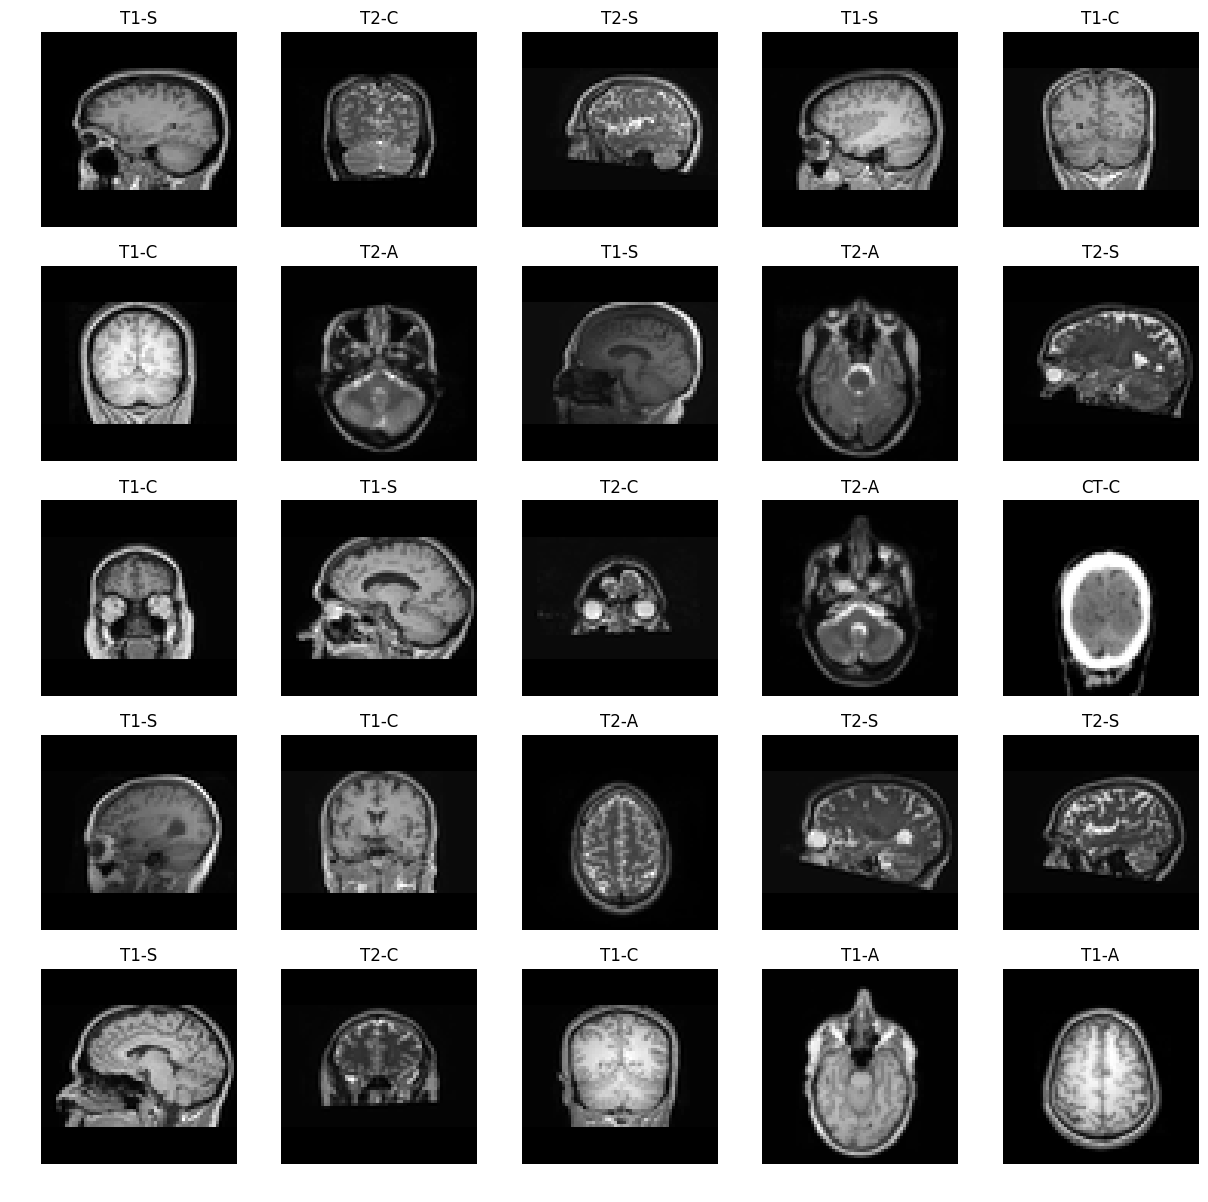

In [12]:
nb_x = 5
nb_y = 5
plt.figure(figsize=(15,15*nb_x/nb_y), dpi=100)
for i in range(1, nb_x * nb_y +1):
    plt.subplot(nb_x, nb_y ,i)
    plot_image( X_data[i-1].reshape(desired_width, desired_height) )
    plt.title(rev_med_view[y_data[i-1]])

### C3 - Convert the data shape and type
Unfortunately, there are no clear rules to create train, valid and test sets.

The one presented here is useful and simple when you don't need to randomize your inputs in order to assess size effect nor training stability using k-fold cross-validations.

This solution also plays around with the `reshape` operator of numpy.

In [13]:
# first : convert type
X_data = X_data.astype(np.float32).reshape(-1, desired_width*desired_height) / 255.0
y_data = y_data.astype(np.int32)
print("X_data is:",X_data)
print("y_data is:",y_data)
# second : define training+valid sets vs test set
nb_train = 400                                            # selects only 400 samples from 21314
X_train, y_train = X_data[:nb_train], y_data[:nb_train]
X_test, y_test   = X_data[nb_train:], y_data[nb_train:]
print("The length of X_train is:",len(X_train))
print("The length of y_train is:",len(y_train))
print("The length of X_test is:",len(X_test))
print("The length of y_test is:",len(y_test))


# third : slpit training and valid sets
nb_valid = nb_train * 10 // 100
X_valid, X_train = X_train[:nb_valid], X_train[nb_valid:]
y_valid, y_train = y_train[:nb_valid], y_train[nb_valid:]
print("The length of X_valid is:",len(X_valid))
print("The length of y_valid is:",len(y_valid))
print("The length of X_train is:",len(X_train))
print("The length of y_train is:",len(y_train))

X_data is: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y_data is: [1 5 4 ... 1 5 1]
The length of X_train is: 400
The length of y_train is: 400
The length of X_test is: 20914
The length of y_test is: 20914
The length of X_valid is: 40
The length of y_valid is: 40
The length of X_train is: 360
The length of y_train is: 360


### C4 - Check the output data size and type
We recommend to check as often as needed the shape and type of data.

The first step that must be done is the data visualization.

Don't go further if you can't see what is inside array and tensor!

In [14]:
print(X_train.shape , y_train.shape)
print(X_valid.shape, y_valid.shape )
print(X_test.shape, y_test.shape)
print(X_train.dtype, y_train.dtype)

(360, 4096) (360,)
(40, 4096) (40,)
(20914, 4096) (20914,)
float32 int32


> _**All done, go to the network!**_

# D - Simple Keras Neural Network 

The simplest way to create, train and test a network, is the _Sequential container_ (Keras or PyTorch).

With a sequential container, you can quickly design a linear stack of layers and so, many kind of models (LSTM, CNN, ...). 

You can have a look at the Keras web documentation at: 
https://keras.io/getting-started/sequential-model-guide/

### D1 - Here we create a simple Multilayer Perceptron (MLP) for multi-class softmax classification

In [15]:
if 'sess' in locals():     # this code prevent creating many intance of
    tf.reset_default_graph()
    sess.close()           # tensorflow in memory (that can cause crashes)

image_size = desired_height * desired_width
nb_neurons = 96

    
sess = tf.InteractiveSession() 

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(nb_neurons, input_shape=(image_size,), activation=tf.nn.relu),  # a fully-connected layer with 16 hidden units
  tf.keras.layers.Dense(9, activation=tf.nn.softmax)
])


### D2 - Then we configure the model for the trainning step

In [16]:
nb_epochs = 10
learning_rate = 1e-3

my_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(optimizer=my_optimizer,                  # For optimizers' list and parameters see: https://keras.io/optimizers/ 
              loss='sparse_categorical_crossentropy',  # list of loss functions: https://keras.io/losses/
              metrics=['accuracy'])                    # list of available metrics: https://keras.io/metrics/

### D3 - **Now let's train the model on 10 epochs**

In [17]:
model.fit(X_train, y_train, epochs=nb_epochs)

Epoch 1/10
360/360 [==============================] - 0s 766us/step - loss: 1.5056 - acc: 0.5194
Epoch 2/10
360/360 [==============================] - 0s 101us/step - loss: 0.5325 - acc: 0.8972
Epoch 3/10
360/360 [==============================] - 0s 104us/step - loss: 0.2832 - acc: 0.9333
Epoch 4/10
360/360 [==============================] - 0s 108us/step - loss: 0.1898 - acc: 0.9444
Epoch 5/10
360/360 [==============================] - 0s 105us/step - loss: 0.1433 - acc: 0.9667
Epoch 6/10
360/360 [==============================] - 0s 104us/step - loss: 0.1006 - acc: 0.9861
Epoch 7/10
360/360 [==============================] - 0s 102us/step - loss: 0.0759 - acc: 0.9917
Epoch 8/10
360/360 [==============================] - 0s 106us/step - loss: 0.0631 - acc: 0.9944
Epoch 9/10
360/360 [==============================] - 0s 102us/step - loss: 0.0535 - acc: 0.9972
Epoch 10/10
360/360 [==============================] - 0s 105us/step - loss: 0.0457 - acc: 0.9972


> **If you want to run more epoch, just run again the cell above!** and see how accuracy converges to 1 ;)

### D4 - Check the accuray on the test set

In [18]:
model.evaluate(X_test, y_test)

20914/20914 [==============================] - 1s 53us/step


[0.1669197944740589, 0.9728411590322272]

> **Question 1** : It is not so bad! But try to increase the number of hidden neuron in the model (D1) to improve the test accuracy.

> **Question 2** : Ok, we use only 400 images. Increase their number and verify that the test accuracy is improved.

> **Question 3** : For fun, add a Dropout layer to your model between the Dense layers. (https://keras.io/layers/core/)

### D5 - Focus on one test prediction

Making test and evaluation on a large data set is nice for assessment, but what about _a_ given result?

The following code performs a label prediction on the image $i$ in the test set:

In [19]:
i = 2000

x_t = X_test[i].reshape(1,-1)        # go from (4096) to (1,4096)

y_t = model.predict(x_t)             # apply the model on the given input
print("label propabilities : ", y_t) 

label propabilities :  [[5.8657486e-02 1.3007552e-03 2.0293583e-06 3.8599253e-02 3.9260773e-05
  6.3538522e-07 8.7852591e-01 1.7471998e-03 2.1127453e-02]]


> **Complete the following line** which should print the true label from ```y_test``` and the predicted one from ```y_t```:

In [20]:
print( "true label      : ", y_test[i] ) 
maximum = np.max(y_t)
print(maximum)
print( "predicted label : ",  np.argmax(y_t))   

true label      :  6
0.8785259
predicted label :  6


### D6 - Displaying the image is **always** a good idea.

Text(0.5, 1.0, 'true: CT-A, predict: CT-A')

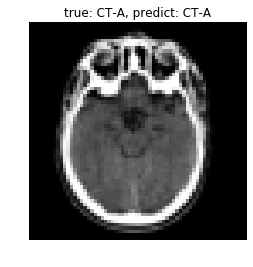

In [22]:
plot_image( X_test[i].reshape(desired_width, desired_height) )
plt.title("true: " + rev_med_view[y_test[i]] + ", predict: " + rev_med_view[np.argmax(y_t)])

### D7 - See the model architecture

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                393312    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 873       
Total params: 394,185
Trainable params: 394,185
Non-trainable params: 0
_________________________________________________________________


### D8 - Save the model weights and close the session

In [24]:
model.save_weights('my_simple_Keras_weights.h5')
model.save('my_simple_Keras_model.h5')

In [25]:
sess.close() # close de session

### D9 - Create a new session and load the weights

In [26]:
loaded_model = tf.keras.models.load_model('my_simple_Keras_model.h5')
loaded_model.summary()

loaded_model.evaluate(X_test, y_test)


# The following lines only save the weights and not the model nor optimizer
#read_model = tf.keras.models.Sequential([
#  tf.keras.layers.Dense(16, input_shape=(image_size,) , activation=tf.nn.relu ),  # a fully-connected layer with 16 hidden units
#  tf.keras.layers.Dense(9, activation=tf.nn.softmax)
#])
#read_model.compile(optimizer='adam',                        # For optimizers' list and parameters see: https://keras.io/optimizers/ 
#              loss='sparse_categorical_crossentropy',  # list of loss functions: https://keras.io/losses/
#              metrics=['accuracy'])    
#read_model.load_weights('my_simple_Keras_weights.h5', by_name=True )
#read_model.summary()
#read_model.evaluate(X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                393312    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 873       
Total params: 394,185
Trainable params: 394,185
Non-trainable params: 0
_________________________________________________________________
20914/20914 [==============================] - 1s 48us/step


[0.1669197944740589, 0.9728411590322272]

### D10 - Watch learning curves

The following lines allow you to train and to display accuracy and loss evolution across iterations.
> **Add your model and create a session to make it working**

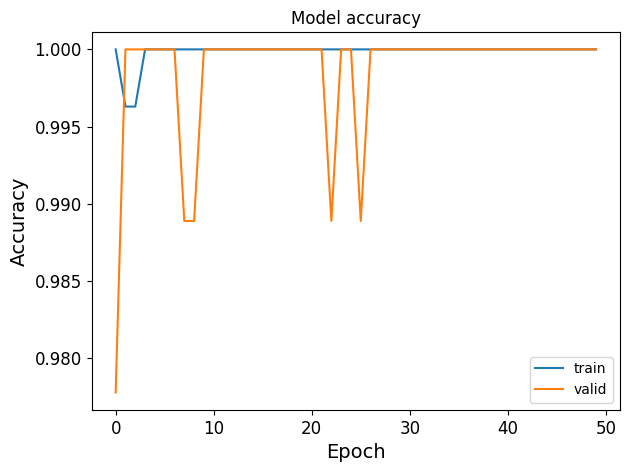

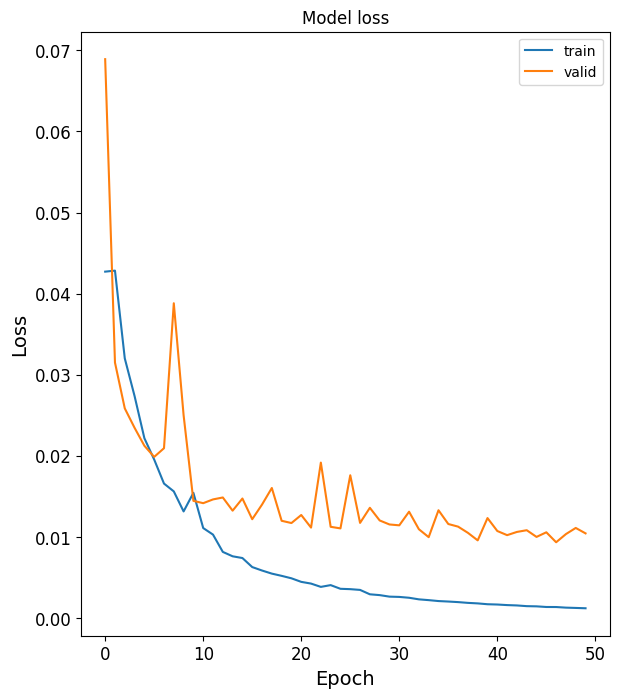

In [27]:
### COMPLETE HERE ####
#model = ...

model = tf.keras.models.load_model('my_simple_Keras_model.h5')

### END HERE ###

# train 
history = model.fit(X_train, y_train, validation_split=0.25, epochs=50, batch_size=16, verbose=0)


# Plot training & validation accuracy values
plt.figure(figsize=(15,5), dpi=100)
plt.subplot(1, 2 ,1)
plt.plot(history.history['acc'], label="train")
plt.plot(history.history['val_acc'], label="valid")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend( )
plt.show()


# Plot training & validation loss values
plt.figure(figsize=(15,8), dpi=100)
plt.subplot(1, 2 ,2)
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="valid")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( )
plt.show()

> **Change the training parameters and try to see an overfitting effect**

> Tensorflow use Tensorboard to display such curves during the training

# E - Convolutional Neural Network

Now we will create a neural network using convolutional layers.

Here, two API levels (Keras and TensorFlow) are used to see how you can use them and how you can control everything.


In [28]:
from datetime import datetime


height   = desired_height
width    = desired_width
channels = 1
n_inputs = height * width

conv1_fmaps  = 8
conv1_ksize  = 3
conv1_stride = 1
conv1_pad    = "SAME"

conv2_fmaps  = 16
conv2_ksize  = 3
conv2_stride = 2
conv2_pad    = "SAME"

pool3_fmaps  = conv2_fmaps

n_fc1     = 16
n_outputs = 9

if 'sess' in locals():     # this code prevent creating many intance of
    tf.reset_default_graph()
    sess.close()           # tensorflow in memory (that can cause crashes)


with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")


conv1 = tf.keras.layers.Conv2D(filters=conv1_fmaps, kernel_size=conv1_ksize,
                           strides=conv1_stride, padding=conv1_pad,
                           activation=tf.nn.relu, name="conv1")(X_reshaped)

# Fully Tensorflow code 
#conv1 = tf.nn.conv2d(
#    X_reshaped,
#    tf.Variable(tf.random_normal([conv1_ksize, conv1_ksize, 1, conv1_fmaps])),
#    strides=[1, conv1_stride, conv1_stride, 1],
#    padding=conv1_pad,
#    name="conv1")
#conv1 = tf.nn.bias_add(conv1, tf.Variable(tf.random_normal([conv1_fmaps])))
#conv1 = tf.nn.relu(conv1)



conv2 = tf.keras.layers.Convolution2D(filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")(conv1)


with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    shape_pool3 = pool3.get_shape()  
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * shape_pool3[1] * shape_pool3[2] ])

with tf.name_scope("fc1"):
    fc1 = tf.keras.layers.Dense(n_fc1, activation=tf.nn.relu, name="fc1")(pool3_flat)

with tf.name_scope("output"):
    logits = tf.keras.layers.Dense( n_outputs, name="output")(fc1)
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()


In [29]:


accuracy_summary = tf.summary.scalar('Accuracy', accuracy)
loss_summary = tf.summary.scalar('loss', loss)



We check how the input size changes at each layer.

In [30]:
print("conv1 ", conv1.get_shape())
print("conv2 ", conv2.get_shape())
print("pool3 ", pool3.get_shape())
print("pool3_flat ", pool3_flat.get_shape())

conv1  (?, 64, 64, 8)
conv2  (?, 32, 32, 16)
pool3  (?, 16, 16, 16)
pool3_flat  (?, 4096)


TensorFlow is linked to a board able to display many informations about the graph and the training curves.
You can launch TensorBoard using the link at the bottom of the frame:

![Figure 1](./images_TP4/TensorBoard.png)

### E1 - Dealing with batch sizes

A commonly used function to shuffle batches accross epochs:

In [31]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

### E2 - Let's train!

We use the validation dataset to check overfitting

In [32]:
n_epochs = 100
batch_size = 100 #100
n_batches = len(X_train) // batch_size

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        batch_index = 0
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):          
            if batch_index % 10 == 0:
                summary_acc_str  = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_acc_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            batch_index += 1
            
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Last batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

        save_path = saver.save(sess, "./my_cnn_model")
file_writer.close()

0 Last batch accuracy: 0.38333333 Validation accuracy: 0.375
1 Last batch accuracy: 0.35833332 Validation accuracy: 0.35
2 Last batch accuracy: 0.425 Validation accuracy: 0.325
3 Last batch accuracy: 0.35833332 Validation accuracy: 0.325
4 Last batch accuracy: 0.425 Validation accuracy: 0.35
5 Last batch accuracy: 0.41666666 Validation accuracy: 0.375
6 Last batch accuracy: 0.45833334 Validation accuracy: 0.375
7 Last batch accuracy: 0.43333334 Validation accuracy: 0.35
8 Last batch accuracy: 0.725 Validation accuracy: 0.625
9 Last batch accuracy: 0.7583333 Validation accuracy: 0.625
10 Last batch accuracy: 0.6666667 Validation accuracy: 0.725
11 Last batch accuracy: 0.8 Validation accuracy: 0.75
12 Last batch accuracy: 0.81666666 Validation accuracy: 0.75
13 Last batch accuracy: 0.875 Validation accuracy: 0.9
14 Last batch accuracy: 0.9 Validation accuracy: 0.925
15 Last batch accuracy: 0.94166666 Validation accuracy: 0.925
16 Last batch accuracy: 0.9583333 Validation accuracy: 0.925


The number of trainable parameters can be obtained by the following:
  > **Question** compare with MLP network.

In [52]:
np.sum([np.prod(v.shape) for v in tf.trainable_variables()])

Dimension(66953)

> Can you explain why it is not equal to the number of trainable parameters for the same model on PyTorch?